In [75]:
!pip install pandas scikit-learn matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [76]:
df = pd.read_csv('IMDB.csv', encoding='latin1')

#DATA PREPROCESSING
df.ffill(inplace=True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df['Year'] = df['Year'].str.replace(r'\(|\)', '', regex=True).astype(int)
df['Duration'] = pd.to_numeric(df['Duration'].str.replace(' min', ''))
df['Votes'] = df['Votes'].replace({'\$': '', 'M': ''}, regex=True)
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

label_cols = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']

encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

df.to_csv('movies_processed.csv', index=False)

In [77]:
print(df.isnull().sum())

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12893 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      12893 non-null  object 
 1   Year      12893 non-null  int64  
 2   Duration  12893 non-null  int64  
 3   Genre     12893 non-null  int64  
 4   Rating    12893 non-null  float64
 5   Votes     12893 non-null  float64
 6   Director  12893 non-null  int64  
 7   Actor 1   12893 non-null  int64  
 8   Actor 2   12893 non-null  int64  
 9   Actor 3   12893 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 1.1+ MB


In [80]:
# AVG_RATING
director_avg_rating = df.groupby('Director')['Rating'].mean()
df['Director_Avg_Rating'] = df['Director'].map(director_avg_rating)

actor1_avg_rating = df.groupby('Actor 1')['Rating'].mean()
actor2_avg_rating = df.groupby('Actor 2')['Rating'].mean()

df['Actor1_Avg_Rating'] = df['Actor 1'].map(actor1_avg_rating)
df['Actor2_Avg_Rating'] = df['Actor 2'].map(actor2_avg_rating)

df['Actors_Avg_Rating'] = (df['Actor1_Avg_Rating'] + df['Actor2_Avg_Rating']) / 2

df.drop(['Actor1_Avg_Rating', 'Actor2_Avg_Rating'], axis=1, inplace=True)

In [81]:
X = df[['Year', 'Duration', 'Genre', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3',
        'Director_Avg_Rating', 'Actors_Avg_Rating']]
y = df['Rating']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [84]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



Model Evaluation:
Mean Absolute Error (MAE): 0.46
Mean Squared Error (MSE): 0.47
Root Mean Squared Error (RMSE): 0.69
R² Score: 0.74


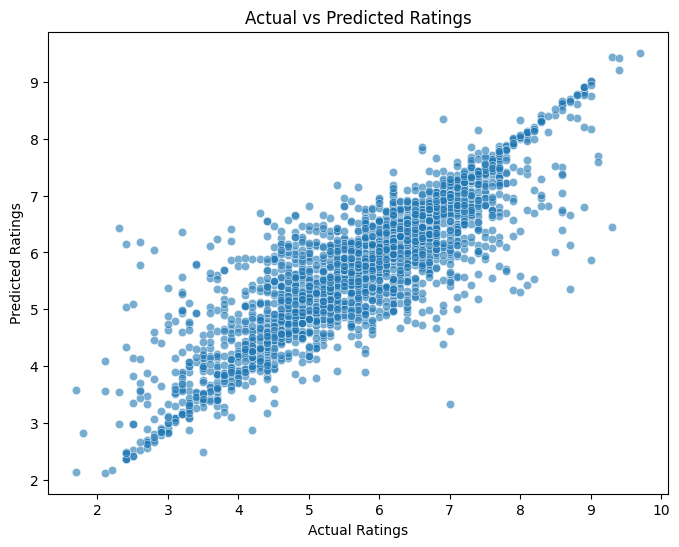

In [89]:
# Scatter Plot: Actual vs Predicted Ratings
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Ratings")
plt.show()

In [85]:
#Test dataframe with actual ratings for comparison
test_data = [
    {'Year': 2022, 'Duration': 120, 'Genre': 'Action', 'Votes': 1000000, 'Director': 'Director X',
     'Actor 1': 'Actor A', 'Actor 2': 'Actor B', 'Actor 3': 'Actor C',
     'Director_Avg_Rating': 7.5, 'Actors_Avg_Rating': 8.0, 'Rating': 7.8},
    {'Year': 2020, 'Duration': 150, 'Genre': 'Drama', 'Votes': 500000, 'Director': 'Director Y',
     'Actor 1': 'Actor D', 'Actor 2': 'Actor E', 'Actor 3': 'Actor F',
     'Director_Avg_Rating': 6.8, 'Actors_Avg_Rating': 7.3, 'Rating': 7.1},
    {'Year': 2021, 'Duration': 95, 'Genre': 'Comedy', 'Votes': 2500000, 'Director': 'Director Z',
     'Actor 1': 'Actor G', 'Actor 2': 'Actor H', 'Actor 3': 'Actor I',
     'Director_Avg_Rating': 8.2, 'Actors_Avg_Rating': 8.5, 'Rating': 8.3}
]

test_df = pd.DataFrame(test_data)

actual_ratings = test_df['Rating'].copy()

test_df_features = test_df.drop('Rating', axis=1)

for col in ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']:
    safe_value = int(df[col].median())
    test_df_features[col] = safe_value

test_df_features = test_df_features[X.columns]

test_predictions = model.predict(test_df_features)

test_df['Predicted_Rating'] = test_predictions

test_df['Rating_Difference'] = test_df['Rating'] - test_df['Predicted_Rating']
test_df['Absolute_Difference'] = abs(test_df['Rating_Difference'])

print("\nRatings Comparison:")
print(test_df[['Rating', 'Predicted_Rating', 'Rating_Difference', 'Absolute_Difference']])

mae = mean_absolute_error(actual_ratings, test_predictions)
rmse = np.sqrt(mean_squared_error(actual_ratings, test_predictions))

print(f"\nMean Absolute Error (MAE) on test data: {mae:.2f}")
print(f"Root Mean Squared Error (RMSE) on test data: {rmse:.2f}")


Ratings Comparison:
   Rating  Predicted_Rating  Rating_Difference  Absolute_Difference
0     7.8            7.9475            -0.1475               0.1475
1     7.1            7.2835            -0.1835               0.1835
2     8.3            8.4775            -0.1775               0.1775

Mean Absolute Error (MAE) on test data: 0.17
Root Mean Squared Error (RMSE) on test data: 0.17


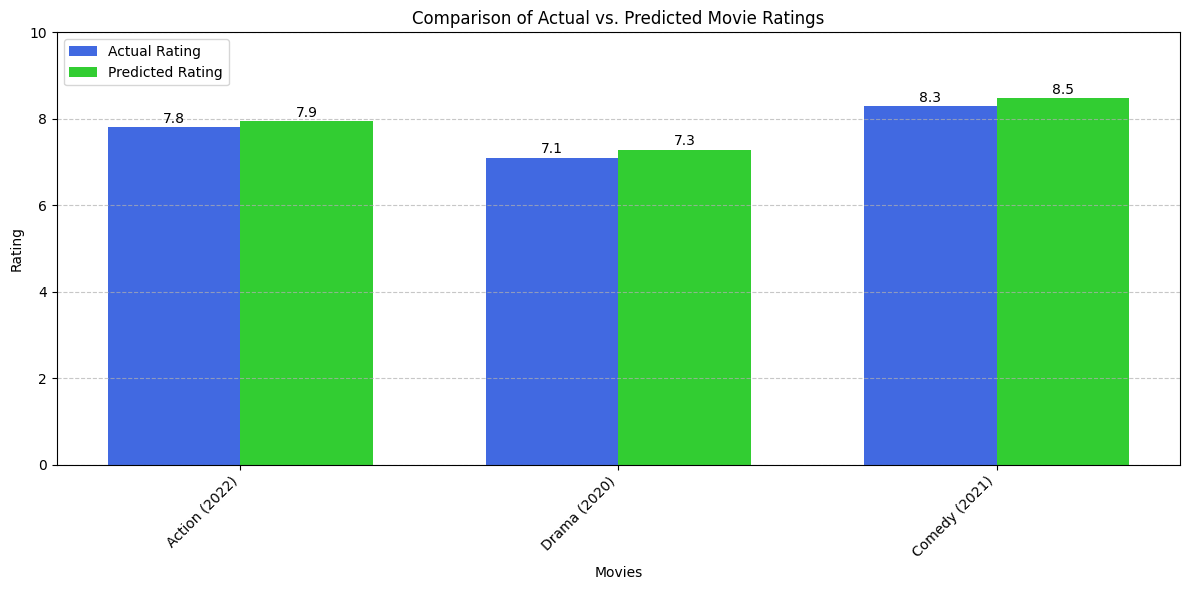

In [88]:
# Graph of Tests
movies = ['Action (2022)', 'Drama (2020)', 'Comedy (2021)']
test_df['Movie'] = movies

plt.figure(figsize=(12, 6))

x = np.arange(len(movies))
width = 0.35

plt.bar(x - width/2, test_df['Rating'], width, label='Actual Rating', color='royalblue')
plt.bar(x + width/2, test_df['Predicted_Rating'], width, label='Predicted Rating', color='limegreen')

plt.xlabel('Movies')
plt.ylabel('Rating')
plt.title('Comparison of Actual vs. Predicted Movie Ratings')
plt.xticks(x, movies, rotation=45, ha='right')
plt.ylim(0, 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()

for i, v in enumerate(test_df['Rating']):
    plt.text(i - width/2, v + 0.1, f'{v:.1f}', ha='center')

for i, v in enumerate(test_df['Predicted_Rating']):
    plt.text(i + width/2, v + 0.1, f'{v:.1f}', ha='center')

mae = mean_absolute_error(test_df['Rating'], test_df['Predicted_Rating'])

plt.tight_layout()
plt.show()